In [1]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join, exists
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
from copy import deepcopy
from utils import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from scipy.optimize import least_squares
%matplotlib inline

This Python notebook runs multi-variate regressions with various Bass model parameters as dependent variables and socioconomic characteristics as independent variables. R code blocks are inserted for running regressions. 

Figure 3 and 4 in the paper can be produced using this notebook.

In [1]:
%load_ext rpy2.ipython

In [4]:
CPI2010 = 320.4 # compared with 2010
CPI_dict = {2000: 252.9, 2001: 260.1, 2002: 264.2, 2003: 270.2, 2004: 277.5,
            2005: 286.9, 2006: 296.2, 2007:  304.6, 2008: 316.3, 2009: 315.2, 2010: 320.4, 2011: 330.5, 
           2012: 337.5, 2013: 342.5, 2014: 348.3, 2015: 348.9, 2016: 353.4, 2017: 361.0, 2018: 369.8, 2019: 376.5}
inflation_adj_rate = {x: CPI2010 / CPI_dict[x] for x in CPI_dict}
inflation_adj_rate_df = pd.DataFrame(inflation_adj_rate.items())
inflation_adj_rate_df.columns = ['year', 'inflation_adj_rate']

In [5]:
def make_str(depedent, features):
    """Generate the formula string given a dependent variable and a list of features"""
    assert features
    s = depedent + ' ~ ' + features[0]
    for f in features[1:]:
        s += ' + ' + f
    return s

# 1. Load data

In [6]:
bg = pd.read_csv('results/merged_bg.csv')
bg['tract_FIPS'] = bg['blockgroup_FIPS'] // 10
bg['county_FIPS'] = bg['blockgroup_FIPS'] // 10000000
bg['state_FIPS'] = bg['blockgroup_FIPS'] // 10000000000

In [7]:
df = bg.sort_values(['year', 'blockgroup_FIPS'])

In [8]:
# Calculate cumulative PV installations in each year
cumulative_pv_count_dict = {}
cumulative_pv_count = np.array(df[df['year'] == 2005]['num_of_installations'])
cumulative_pv_count_dict[2005] = cumulative_pv_count.copy()
for year in range(2006, 2018):
    cumulative_pv_count = cumulative_pv_count + np.array(df[df['year'] == year]['num_of_installations'])
    cumulative_pv_count_dict[year] = cumulative_pv_count.copy()

In [9]:
df['cum_num_of_installations'] = np.concatenate([cumulative_pv_count_dict[x] for x in cumulative_pv_count_dict])
df.sort_values(['blockgroup_FIPS', 'year'], inplace=True)

In [10]:
# Create static ACS variables
ACS_cols = [x for x in df.columns if x[:3] == 'ACS']
ACS2016_sub = df[df['year'] == 2016][['blockgroup_FIPS'] + ACS_cols]
rename_dict_ACS = {x: x + '_2016' for x in ACS_cols}
ACS2016_sub.rename(columns=rename_dict_ACS, inplace=True)
df = pd.merge(df, ACS2016_sub, how='left', on='blockgroup_FIPS')

In [11]:
# Calculate the cumulative installations in previous year
prev_year_cum = df[(df['year'] <= 2015) & (df['year'] >= 2005)][['blockgroup_FIPS', 
                                                                 'year',
                                                                 'cum_num_of_installations']]
# prev_year_cum.index = prev_year_cum['blockgroup_FIPS']
prev_year_cum.rename(columns={'cum_num_of_installations': 'cum_num_of_installations_prev'}, inplace=True)
prev_year_cum['year'] = prev_year_cum['year'] + 1

In [12]:
df_sub = df[(df['year'] <= 2016) & (df['year'] >= 2006)]
df_sub = pd.merge(df_sub, prev_year_cum, how='left', on=['blockgroup_FIPS', 'year'])

In [13]:
# number of installations in each year
adoption_matrix_bg = pd.DataFrame(df_sub['num_of_installations'].to_numpy().reshape([-1, 11]))
adoption_matrix_bg.index = df_sub[df_sub['year'] == 2016]['blockgroup_FIPS']
adoption_matrix_bg.columns = [str(x) for x in range(2006, 2017)]

In [14]:
# cumulative number of installations till previous year
cum_adoption_matrix_prev_bg = pd.DataFrame(df_sub['cum_num_of_installations_prev'].to_numpy().reshape([-1, 11]))
cum_adoption_matrix_prev_bg.index = df_sub[df_sub['year'] == 2016]['blockgroup_FIPS']
cum_adoption_matrix_prev_bg.columns = [str(x) for x in range(2006, 2017)]

In [15]:
# cumulative number of installations till each year
cum_adoption_matrix_bg = pd.DataFrame(df[df['year'] <= 2016]['cum_num_of_installations'].to_numpy().reshape([-1, 12]))
cum_adoption_matrix_bg.index = df[df['year'] == 2016]['blockgroup_FIPS']
cum_adoption_matrix_bg.columns = [str(x) for x in range(2005, 2017)]

In [16]:
del bg

# 2. Derive profit margin and rebate by year

In [17]:
def get_t_by_cum_adoption_rate(p, q, m, d, cum_adoption_rate):
    """
    Given a target cumulative rate value, return the time when that this target is reached.
    """
    k = (1 - cum_adoption_rate) / (1 + q/p * cum_adoption_rate)
    t = - np.log(k) / (p + q)
    return t + d

def get_t_by_cum_adoption_amount(p, q, m, d, amount):
    """
    Given a target cumulative amount value, return the time when that this target is reached.
    """
    cum_adoption_rate = np.minimum(amount / m, 0.999999)
    return get_t_by_cum_adoption_rate(p, q, m, d, cum_adoption_rate)

In [18]:
def calculate_LCOE(price_per_kw, OM_cost_per_year, radiation, n_years=30, discount_rate=0.03, performance_ratio=1.):
    """
    price_per_kw: $/kW
    OM_cost_per_year: $/kW/year
    radiation: W/m^2
    performance_ratio: between 0 and 1
    """
    cum_discount_rate = np.sum((1. / (1 + discount_rate)) ** np.arange(1, n_years+1))
    total_cost = price_per_kw / (1 + discount_rate) + cum_discount_rate * OM_cost_per_year
    total_generated_energy = 365 * 24 * (radiation / 1000) * cum_discount_rate * performance_ratio
    return total_cost / total_generated_energy

In [19]:
def calculate_LCOE_2(price_per_kw, OM_cost_per_year, radiation, n_years=30, discount_rate=0.03, performance_ratio=1.):
    """
    price_per_kw: $/kW
    OM_cost_per_year: $/kW/year
    radiation: W/m^2
    performance_ratio: between 0 and 1
    """
    CF = radiation / 1000.
    nominator = price_per_kw * ((1 + discount_rate) ** (n_years) * discount_rate) /\
                ((1 + discount_rate) ** n_years - 1) + OM_cost_per_year
    denominator = 8760 * CF
    return nominator / denominator

In [20]:
def calculate_levelized_electricity_rate(electricity_rate, n_years=30, discount_rate=0.03, cost_escalation_rate=0.07):
    """
    electricity rate: $/kWh
    """
    if cost_escalation_rate == discount_rate:
        nominator = n_years * electricity_rate
    else:
        nominator = electricity_rate * (1 - ((1+cost_escalation_rate) / (1+discount_rate)) ** n_years) /\
                        (1 - ((1+cost_escalation_rate) / (1+discount_rate))) * ((1+cost_escalation_rate) / (1+discount_rate))
    denominator = (1 - 1 / ((1+discount_rate) ** n_years)) / (1 - 1 / (1 + discount_rate)) * (1 / (1+discount_rate))
    return nominator / denominator

In [21]:
# PV price per kW, rebate per kW, and PV module efficiency, from Tracking the Sun dataset
price_by_county = pd.read_csv(
    'data/socioeconomics/price_and_efficiency_TTS/pv_price_by_county.csv')
rebate_by_county = pd.read_csv(
    'data/socioeconomics/price_and_efficiency_TTS/rebate_or_grant_by_county.csv')
efficiency_by_state = pd.read_csv(
    'data/socioeconomics/price_and_efficiency_TTS/pv_efficiency_by_state.csv')
efficiency_overall = pd.read_csv(
    'data/socioeconomics/price_and_efficiency_TTS/pv_efficiency_us_overall.csv')

In [22]:
# create searching dict
efficiency_overall_dict = {}
for i in efficiency_overall.index:
    year = efficiency_overall.loc[i, 'year']
    efficiency_overall_dict[year] = efficiency_overall.loc[i, 'efficiency_median']
    
efficiency_by_state_dict = {}
for i in efficiency_by_state.index:
    year = efficiency_by_state.loc[i, 'year']
    state_abbr = efficiency_by_state.loc[i, 'state_abbr']
    efficiency_by_state_dict[(state_abbr, year)] = efficiency_by_state.loc[i, 'efficiency_median']
    
price_by_county_dict = {}
for i in price_by_county.index:
    year = price_by_county.loc[i, 'year']
    cfips = price_by_county.loc[i, 'county_FIPS']
    price_by_county_dict[(cfips, year)] = price_by_county.loc[i, 'price_per_kw_median_inflation_adj']
    
rebate_by_county_dict = {}
for i in rebate_by_county.index:
    year = rebate_by_county.loc[i, 'year']
    cfips = rebate_by_county.loc[i, 'county_FIPS']
    rebate_by_county_dict[(cfips, year)] = rebate_by_county.loc[i, 'rebate_or_grant_per_kw_median_inflation_adj']

In [24]:
# imputed price and rebate
imputed_prices = pd.read_csv('data/socioeconomics/price_and_efficiency_TTS/pv_median_price_by_county_imputed.csv')
imputed_prices.index = imputed_prices['county_FIPS']

# imputed rebate
imputed_rebates = pd.read_csv('data/socioeconomics/price_and_efficiency_TTS/rebate_by_county_imputed.csv')
imputed_rebates.index = imputed_rebates['county_FIPS']


In [25]:
# electricity rate
rate_tract = pd.read_csv('data/socioeconomics/electricity_rate_nrel/electricity_rate_by_tract_year.csv')
rate_tract_2 = pd.read_csv(
    'data/socioeconomics/electricity_rate_nrel/electricity_rate_by_tract_year_363counties.csv')
rate_tract_3 = pd.read_csv(
    'data/socioeconomics/electricity_rate_nrel/electricity_rate_by_tract_year_2718counties.csv')
rate_tract = pd.concat([rate_tract, rate_tract_2, rate_tract_3], ignore_index=True)
rate_tract.rename(columns={'fips': 'tract_FIPS'}, inplace=True)

# adjust by inflation for electricity rates
for x in ['residential_rate', 'commercial_rate', 'industrial_rate']:
    rate_tract[x + '_inflation_adj'] = 0.
    for year in range(2005, 2018):
         rate_tract[x + '_inflation_adj'] += (rate_tract['year'] == year) * rate_tract[x] * inflation_adj_rate[year]

In [26]:
# map (tract FIPS, year) to its corresponding electricity rate
rate_tract_dict = {}
for i in rate_tract.index:
    year = rate_tract.loc[i, 'year']
    tfips = rate_tract.loc[i, 'tract_FIPS']
    rate_tract_dict[(tfips, year)] = rate_tract.loc[i, 'residential_rate_inflation_adj']

In [27]:
# Operation & maintanance cost per year
# https://www.nrel.gov/docs/fy21osti/77324.pdf, page 28
OM_cost_per_year_dict = {2010: 56, 2011: 49, 2012: 42, 2013: 36, 2014: 31, 2015: 26, 2016: 25, 2017: 25, 2018: 25}
for x in OM_cost_per_year_dict:
    OM_cost_per_year_dict[x] = OM_cost_per_year_dict[x] * inflation_adj_rate[2019]
# As OM cost data is not available before 2010, we use 0.007 * median price_per_kw_median_inflation_adj as a proxy
for x in [2005, 2006, 2007, 2008, 2009]:
    OM_cost_per_year_dict[x] = 0.007 * price_by_county.groupby('year').agg(
                                                                'mean').loc[x, 'price_per_kw_median_inflation_adj']

In [28]:
merged2 = pd.read_csv('results/bass_model/merged_bg_bass.csv')

In [29]:
# The year when 1st PV was installed in a blockgroup, predicted by fitted Bass model
merged2['predicted_1st_adoption_time'] = \
        get_t_by_cum_adoption_amount(merged2['p'], merged2['q'], merged2['m'], merged2['d'], 1)
merged2['state_FIPS'] = merged2['state_FIPS'].astype(str)

In [30]:
# The year when 1st PV was installed in a blockgroup, observed in the data
l = []
for i in merged2.index:
    bfips = merged2.loc[i, 'blockgroup_FIPS']
    first_year = None
    for year in range(2005, 2017):
        if cum_adoption_matrix_bg.loc[bfips, str(year)] > 0:
            first_year = year
            break
    l.append(first_year)
merged2['actual_1st_adoption_time'] = l
merged2['actual_1st_adoption_time'] -= 2006

In [31]:
ss = merged2[['d', 'actual_1st_adoption_time', 'predicted_1st_adoption_time']]
ss = ss.dropna()
ss['predicted_1st_adoption_time'] = np.maximum(-1, ss['predicted_1st_adoption_time'])
ss['d'] = np.maximum(-1, ss['d'])
r2_score(ss['actual_1st_adoption_time'], ss['predicted_1st_adoption_time'])

0.7414369110995214

In [32]:
merged2['d_rounded'] = np.round(merged2['d'], 0) + 2006
merged2['predicted_1st_adoption_time_rounded'] = np.round(merged2['predicted_1st_adoption_time'], 0) + 2006
merged2['actual_1st_adoption_time_rounded'] = np.round(merged2['actual_1st_adoption_time'], 0) + 2006

## 2.1 Cost and benefit at the onset

In [33]:
anchor_year_col = 'd_rounded'
l = []
for i in merged2[merged2[anchor_year_col].isnull() == False].index:
    bfips = merged2.loc[i, 'blockgroup_FIPS']
    tfips = bfips // 10
    cfips = bfips // 10000000
    GHI = merged2.loc[i, 'avg_GHI']
    anchor_year = int(merged2.loc[i, anchor_year_col])
#     anchor_year = 2010
    if anchor_year > 2017 or anchor_year < 2005:
        continue
    if (cfips, anchor_year) not in price_by_county_dict:
        continue
    efficiency = efficiency_overall_dict[anchor_year]
    OM_cost_per_year = OM_cost_per_year_dict[anchor_year]
    price_per_kw = price_by_county_dict[(cfips, anchor_year)]
    res_rate = rate_tract_dict[(tfips, anchor_year)]
    lcoe = price_per_kw / (GHI * 1.0)
    calculated_lcoe = calculate_LCOE_2(price_per_kw, OM_cost_per_year, GHI, 
                                     n_years=30, discount_rate=0.04, performance_ratio=1.)
    levelized_res_rate = calculate_levelized_electricity_rate(res_rate, 
                                     n_years=30, discount_rate=0.04, cost_escalation_rate=0.01)
    if (cfips, anchor_year) not in rebate_by_county_dict:
        rebate_per_kw = None
        calculated_lcoe_subsidized = None
        price_per_kw_subsidized = None
    else:
        rebate_per_kw = rebate_by_county_dict[(cfips, anchor_year)]
        calculated_lcoe_subsidized = calculate_LCOE_2(price_per_kw - rebate_per_kw, OM_cost_per_year, GHI, 
                                     n_years=30, discount_rate=0.04, performance_ratio=1.)
        price_per_kw_subsidized = price_per_kw - rebate_per_kw
        
    l.append([bfips, price_per_kw, price_per_kw_subsidized, rebate_per_kw,
              res_rate, levelized_res_rate, lcoe, calculated_lcoe, calculated_lcoe_subsidized])
cost_benefit_onset_df = pd.DataFrame(l)
cost_benefit_onset_df.columns = [
    'blockgroup_FIPS',
    'price_per_kw_onset',
    'price_per_kw_subsidized_onset',
    'rebate_or_grant_per_kw_onset',
    'residential_rate_onset', 
    'residential_rate_levelized_onset',
    'LCOE_uncalibrated_onset',
    'LCOE_calculated_onset',
    'LCOE_calculated_subsidized_onset',
]

In [34]:
# Calibration
dependent = 'LCOE_uncalibrated_onset'
features = [
    'residential_rate_onset',
]
results_calibration = smf.ols(make_str(dependent, features), data=cost_benefit_onset_df).fit(cov_type='HC1')
print(results_calibration.summary())

                               OLS Regression Results                              
Dep. Variable:     LCOE_uncalibrated_onset   R-squared:                       0.035
Model:                                 OLS   Adj. R-squared:                  0.035
Method:                      Least Squares   F-statistic:                     304.6
Date:                     Wed, 07 Sep 2022   Prob (F-statistic):           2.36e-67
Time:                             11:58:52   Log-Likelihood:                -45144.
No. Observations:                    11715   AIC:                         9.029e+04
Df Residuals:                        11713   BIC:                         9.031e+04
Df Model:                                1                                         
Covariance Type:                       HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

62.631243406307966 23.520413150524803


Text(0, 0.5, 'p / r at the onset')

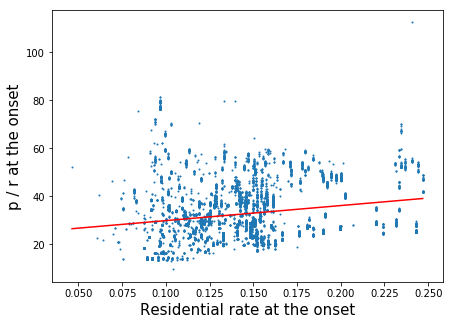

In [35]:
plt.figure(figsize=(7, 5))
print(results_calibration.params['residential_rate_onset'],results_calibration.params['Intercept'])
plt.scatter(
    cost_benefit_onset_df['residential_rate_onset'], 
    cost_benefit_onset_df['LCOE_uncalibrated_onset'], 
    s=1)
x1 = cost_benefit_onset_df['residential_rate_onset'].min()
x2 = cost_benefit_onset_df['residential_rate_onset'].max()
y1 = results_calibration.params['residential_rate_onset'] * x1 + results_calibration.params['Intercept']
y2 = results_calibration.params['residential_rate_onset'] * x2 + results_calibration.params['Intercept']
plt.plot([x1, x2], [y1, y2], color='red')
plt.xlabel('Residential rate at the onset', fontsize=15)
plt.ylabel('p / r at the onset', fontsize=15)
# plt.ylim(0, 100)

In [36]:
cost_benefit_onset_df['rate_LCOE_diff_calibrated_onset'] =\
    results_calibration.params['residential_rate_onset'] * cost_benefit_onset_df['residential_rate_onset'] -\
    cost_benefit_onset_df['LCOE_uncalibrated_onset']


In [37]:
# derived variables
cost_benefit_onset_df['rate_LCOE_diff_calculated_onset'] =\
    cost_benefit_onset_df['residential_rate_onset'] - cost_benefit_onset_df['LCOE_calculated_onset']
cost_benefit_onset_df['rate_LCOE_diff_subsidized_calculated_onset'] =\
    cost_benefit_onset_df['residential_rate_onset'] - cost_benefit_onset_df['LCOE_calculated_subsidized_onset']
cost_benefit_onset_df['levelized_rate_LCOE_diff_calculated_onset'] =\
    cost_benefit_onset_df['residential_rate_levelized_onset'] - cost_benefit_onset_df['LCOE_calculated_onset']
cost_benefit_onset_df['levelized_rate_LCOE_diff_subsidized_calculated_onset'] =\
cost_benefit_onset_df['residential_rate_levelized_onset'] - cost_benefit_onset_df['LCOE_calculated_subsidized_onset']

## 2.2 Cost and benefit by year

In [38]:
# Use imputed price and rebate
l = []
for i in tqdm(merged2.index):
    bfips = merged2.loc[i, 'blockgroup_FIPS']
    tfips = bfips // 10
    cfips = bfips // 10000000
    GHI = merged2.loc[i, 'avg_GHI']
    for anchor_year in range(2005, 2018):
        OM_cost_per_year = OM_cost_per_year_dict[anchor_year]
        if cfips not in imputed_prices.index:
            continue
        price_per_kw = imputed_prices.loc[cfips, str(anchor_year)]
        price_per_kw = max(price_per_kw, 0) # bounded to be >= 0 !!!
        
        res_rate = rate_tract_dict[(tfips, anchor_year)]
        lcoe = price_per_kw / (GHI * 1.0)
        calculated_lcoe = calculate_LCOE_2(price_per_kw, OM_cost_per_year, GHI, 
                                         n_years=30, discount_rate=0.04, performance_ratio=1.)
        levelized_res_rate = calculate_levelized_electricity_rate(res_rate, 
                                     n_years=30, discount_rate=0.04, cost_escalation_rate=0.01)
        
        if cfips not in imputed_rebates.index:
            rebate_per_kw = None
            calculated_lcoe_subsidized = None
            price_per_kw_subsidized = None
        
        else:
            rebate_per_kw = imputed_rebates.loc[cfips, str(anchor_year)]
            rebate_per_kw = max(rebate_per_kw, 0) # bounded to be >= 0 !!!
            calculated_lcoe_subsidized = calculate_LCOE_2(price_per_kw - rebate_per_kw, OM_cost_per_year, GHI, 
                                     n_years=30, discount_rate=0.04, performance_ratio=1.)
            price_per_kw_subsidized = price_per_kw - rebate_per_kw
        
        l.append([bfips, anchor_year, price_per_kw, price_per_kw_subsidized, rebate_per_kw,
              res_rate, levelized_res_rate, lcoe, calculated_lcoe, calculated_lcoe_subsidized])

cost_benefit_df = pd.DataFrame(l)
cost_benefit_df.columns = [
    'blockgroup_FIPS', 
    'year',
    'price_per_kw',
    'price_per_kw_subsidized',
    'rebate_or_grant_per_kw',
    'residential_rate', 
    'residential_rate_levelized',
    'LCOE_uncalibrated',
    'LCOE_calculated',
    'LCOE_calculated_subsidized',
]

100%|██████████| 54493/54493 [00:13<00:00, 4083.96it/s] 


In [39]:
cost_benefit_df['rate_LCOE_diff_calculated'] = cost_benefit_df['residential_rate'] - cost_benefit_df['LCOE_calculated']
cost_benefit_df['rate_LCOE_diff_subsidized_calculated'] = cost_benefit_df['residential_rate'] -\
                                               cost_benefit_df['LCOE_calculated_subsidized']
cost_benefit_df['levelized_rate_LCOE_diff_calculated'] = cost_benefit_df['residential_rate_levelized'] -\
                                                         cost_benefit_df['LCOE_calculated']
cost_benefit_df['levelized_rate_LCOE_diff_subsidized_calculated'] = cost_benefit_df['residential_rate_levelized'] -\
                                                          cost_benefit_df['LCOE_calculated_subsidized']

In [40]:
# average cost/benefit over 2005-2016
cost_benefit_avg = cost_benefit_df[
    (cost_benefit_df['year'] >= 2005) & (cost_benefit_df['year'] <= 2016)].groupby('blockgroup_FIPS').agg('mean')
del cost_benefit_avg['year']
cost_benefit_avg.columns = [x + '_avg' for x in cost_benefit_avg.columns]

In [41]:
cost_benefit_2016 = cost_benefit_df[cost_benefit_df['year'] == 2016]
del cost_benefit_2016['year']
cost_benefit_2016.rename(
    columns={x: x + '_2016' for x in cost_benefit_2016.columns if x != 'blockgroup_FIPS'},
    inplace=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


# 3. Regression

In [44]:
def statsmodel_results_to_df_2(results):
    """Convert the statsmodel results into a dataframe"""
    res = results.params.to_frame(name='coef')
#     res['std err'] = results.HC1_se
    res['std err'] = results.bse
    res['z'] = results.tvalues
    res['P>|z|'] = results.pvalues
    res = res.loc[[x for x in res.index if 'state' not in x or ':' in x], :]
    l = []
    for x in res.index:
        pval = res.loc[x, 'P>|z|']
        if pval < 0.001:
            star = '***'
        elif pval < 0.01:
            star = '**'
        elif pval < 0.05:
            star = '*'
        else:
            star = ''
        l.append(star)
    res['significance'] = l
    return res

In [45]:
def order_variables_by_coefs(coef_list, CI_list, varname_list):
    """
    Sort the coefficients by coefficient value (high to low), sort 
    the coefficient names and CI accordingly.
    """
    combo_list = list(zip(coef_list, CI_list, varname_list))
    combo_list.sort(key=lambda x: x[0], reverse=True)
    coef_list1 = []
    CI_list1 = []
    varname_list1 = []
    for coef, ci, varname in combo_list:
        coef_list1.append(coef)
        CI_list1.append(ci)
        varname_list1.append(varname)
    return coef_list1, CI_list1, varname_list1

In [46]:
def order_variables_by_varnames(coef_list, CI_list, varname_list, signifance_list=None, varname_order=None):
    """
    Sort the coefficients by given varname order, sort 
    the coefficient names and CI accordingly.
    """
    varname_order_dict = {}
    if varname_order:
        for i, varname in enumerate(varname_order):
            varname_order_dict[varname] = i
    return_sigificance = True
    if not signifance_list:
        signifance_list = ['' for i in range(len(coef_list))]
        return_sigificance = False
    for varname in varname_list:
        if varname not in varname_order_dict:
            if 'LCOE' in varname:
                for x in varname_order_dict:
                    if 'LCOE' in x:
                        break
                varname_order_dict[varname] = varname_order_dict[x]
            else:
                varname_order_dict[varname] = 9999
    combo_list = list(zip(coef_list, CI_list, varname_list, signifance_list))
    combo_list.sort(key=lambda x: varname_order_dict[x[2]])
    coef_list1 = []
    CI_list1 = []
    varname_list1 = []
    signifance_list1 = []
    for coef, ci, varname, significance in combo_list:
        coef_list1.append(coef)
        CI_list1.append(ci)
        varname_list1.append(varname)
        signifance_list1.append(significance)
    if return_sigificance:
        return coef_list1, CI_list1, varname_list1, signifance_list1
    else:
        return coef_list1, CI_list1, varname_list1

In [47]:
merged3 = pd.merge(merged2, cost_benefit_onset_df, how='left', on='blockgroup_FIPS')
merged3 = pd.merge(merged3, cost_benefit_avg, how='left', on='blockgroup_FIPS')
merged3 = pd.merge(merged3, cost_benefit_2016, how='left', on='blockgroup_FIPS')

In [48]:
merged3['county_FIPS'] = merged3['blockgroup_FIPS'] // 10000000
merged3['county_FIPS'] = merged3['county_FIPS'].astype(str)

In [49]:
merged3['installation_indicator_2016'] = merged3['blockgroup_FIPS'].isin(
    cum_adoption_matrix_bg[cum_adoption_matrix_bg['2016'] > 0].index).astype(int)

In [50]:
for response in ['ACS_edu_score_2016', 
                 'ACS_occupancy_occupied_renter_rate_2016', 'ACS_housing_unit_median_value_2016']:
    df_reg_sub = merged3[['blockgroup_FIPS', response, 'ACS_median_household_income_2016']]
    df_reg_sub = df_reg_sub.dropna()
    X = df_reg_sub['ACS_median_household_income_2016'].to_numpy().reshape([-1, 1])
    y = df_reg_sub[response].to_numpy()
    lm = LinearRegression()
    lm.fit(X, y)
    y_pred = lm.predict(X)
    print(r2_score(y, y_pred))
    df_reg_sub[response + '_pred'] = y_pred
    df_reg_sub[response + '_residual'] = df_reg_sub[response] - df_reg_sub[response + '_pred']
    merged3 = pd.merge(merged3, df_reg_sub[['blockgroup_FIPS', response + '_residual']], how='left', 
                       on='blockgroup_FIPS')

0.4888968244948154
0.21474396540173235
0.4875631190405393


In [51]:
income_normalized_benefit_mapping = {}

In [52]:
# convert the unit relative benefit of PV from $ to cent
merged3['rate_LCOE_diff_calculated_avg'] *= 100
merged3['levelized_rate_LCOE_diff_calculated_avg'] *= 100
merged3['rate_LCOE_diff_subsidized_calculated_avg'] *= 100
merged3['levelized_rate_LCOE_diff_subsidized_calculated_avg'] *= 100
merged3['rebate_or_grant_per_kw_avg'] *= 100
merged3['price_per_kw_avg'] *= 100
merged3['price_per_kw_subsidized_avg'] *= 100

merged3['rate_LCOE_diff_calculated_2016'] *= 100
merged3['levelized_rate_LCOE_diff_calculated_2016'] *= 100
merged3['rate_LCOE_diff_subsidized_calculated_2016'] *= 100
merged3['levelized_rate_LCOE_diff_subsidized_calculated_2016'] *= 100
merged3['rebate_or_grant_per_kw_2016'] *= 100
merged3['price_per_kw_2016'] *= 100
merged3['price_per_kw_subsidized_2016'] *= 100

merged3['rate_LCOE_diff_calculated_onset'] *= 100
merged3['levelized_rate_LCOE_diff_calculated_onset'] *= 100
merged3['rate_LCOE_diff_subsidized_calculated_onset'] *= 100
merged3['levelized_rate_LCOE_diff_subsidized_calculated_onset'] *= 100
merged3['rebate_or_grant_per_kw_onset'] *= 100
merged3['price_per_kw_onset'] *= 100
merged3['price_per_kw_subsidized_onset'] *= 100

In [54]:
name_dict = {
    'ACS_median_household_income_2016': 'Median household\nincome',
    'ACS_housing_unit_density_2016': 'Housing unit\ndensity',
    'ACS_diversity_NH_2016': 'Racial diversity',
    'ACS_diversity_NH_2016_simpson': 'Racial diversity\n(Simpson\'s index)',
    'ACS_age_median_2016': 'Median age of\npopulation',
    'ACS_occupancy_occupied_rate_2016': 'Housing unit \noccupancy rate',
    'ACS_occupancy_occupied_renter_rate_2016': '% renter-occupied\nhousing units',
    
    'ACS_edu_score_2016': 'Years of education',
    
    'ACS_edu_score_2016_residual': 'Years of education\n(residual)',
    'ACS_occupancy_occupied_renter_rate_2016_residual': '% renter-occupied\nhousing units (residual)',
    'ACS_housing_unit_median_value_2016_residual': 'Median housing unit\nvalue (residual)',
    # 
    'rate_LCOE_diff_calculated_avg': 'Avg. PV benefit',
    'levelized_rate_LCOE_diff_calculated_avg': 'Avg. PV benefit',
    'rate_LCOE_diff_subsidized_calculated_avg': 'Avg. PV benefit\nwith rebate/grant',
    'levelized_rate_LCOE_diff_subsidized_calculated_avg': 'Avg. PV benefit\nwith rebate/grant',
    'rebate_or_grant_per_kw_avg': 'Avg. rebate/grant\nper kW',
    'price_per_kw_avg': 'Avg. PV cost\nper kW',
    'price_per_kw_subsidized_avg': 'Avg. PV cost\nper kW (subsidized)',
    'relative_benefit_avg': 'Avg. relative savings\nof PV (as a share of income)',
    'relative_subsidized_benefit_avg': 'Avg. relative savings\nof PV (with rebate/grant,\nas a share of income)',
    'relative_levelized_benefit_avg': 'Avg. relative savings\nof PV (as a share of income)',
    'relative_levelized_subsidized_benefit_avg': 'Avg. relative savings\nof PV (with rebate/grant,\nas a share of income)',
    # 
    'rate_LCOE_diff_calculated_2016': 'PV benefit in 2016',
    'levelized_rate_LCOE_diff_calculated_2016': 'PV benefit in 2016',
    'rate_LCOE_diff_subsidized_calculated_2016': 'PV benefit with\nrebate/grant in 2016',
    'levelized_rate_LCOE_diff_subsidized_calculated_2016': 'PV benefit with\nrebate/grant in 2016',
    'rebate_or_grant_per_kw_2016': 'Rebate/grant per kW\nin 2016',
    'price_per_kw_2016': 'PV cost per kW\nin 2016',
    'price_per_kw_subsidized_2016': 'PV cost per kW\nin 2016 (subsidized)',
    
    'relative_benefit_2016': 'Relative savings of PV\nin 2016 (as a share of income)',
    'relative_subsidized_benefit_2016': 'Relative savings of PV\nin 2016 (with rebate/grant,\nas a share of income)',
    'relative_levelized_benefit_2016': 'Relative savings of PV\nin 2016 (as a share of income)',
    'relative_levelized_subsidized_benefit_2016': 'Relative savings of PV\nin 2016 (with rebate/grant,\nas a share of income)',
    #
    'rate_LCOE_diff_calculated_onset': 'PV benefit at onset',
    'levelized_rate_LCOE_diff_calculated_onset': 'PV benefit at onset',
    'rate_LCOE_diff_subsidized_calculated_onset': 'PV benefit(with\nrebate/grant) at onset',
    'levelized_rate_LCOE_diff_subsidized_calculated_onset': 'PV benefit(with\nrebate/grant) at onset',
    'rebate_or_grant_per_kw_onset': 'Rebate/grant per kW\nat onset',
    'price_per_kw_onset': 'PV cost per kW\nat onset',
    'price_per_kw_subsidized_onset': 'PV cost per kW\nat onset (subsidized)',
    
    'relative_benefit_onset': 'Relative savings of PV\nat onset (as a share of income)',
    'relative_subsidized_benefit_onset': 'Relative savings of PV\nat onset (with rebate/grant,\nas a share of income)',
    'relative_levelized_benefit_onset': 'Relative savings of PV\nat onset (as a share of income)',
    'relative_levelized_subsidized_benefit_onset': 'Relative savings of PV\nat onset (with rebate/grant,\nas a share of income)',
    #
    'ACS_median_household_income_2016:rate_LCOE_diff_subsidized_calculated_avg': 'Income x\n avg. profit margin',
    'ACS_median_household_income_2016:rate_LCOE_diff_subsidized_calculated_onset': 'Income x\n profit margin at onset',
    'ACS_median_household_income_2016:rate_LCOE_diff_subsidized_calculated_2016': 'Income x\n profit margin in 2016',
    
    'incentive_grant_program': 'Grant',
    'incentive_leasing_program': 'Leasing',
    'incentive_loan_program': 'Loan',
    'incentive_pace_financing': 'PACE',
    'incentive_performance_based_incentive': 'PBI',
    'incentive_property_tax_incentive': 'Property tax\nincentive',
    'incentive_rebate_program': 'Rebate',
    'incentive_utility_rate_discount': 'Utility rate\ndiscount',
    'incentive_property_tax_incentive': 'PTI',
    'incentive_green_building_incentive': 'GBI',
    'incentive_sales_tax_incentive': 'Sales tax\nincentive',
    'incentive_personal_tax_credit': 'Personal tax\ncredit',
    'incentive_feed_in_tariff': 'FiT',
    'incentive_net_metering': 'NEM',
    
    'avg_GHI': 'Avg. GHI',
}

In [55]:
incentive_type_indicator_bg = pd.read_csv(
    'data/incentives/spatiotemporal_res_incentive_type_indicator_bg_420counties.csv')

In [56]:
incentive_type_indicator_2016 = incentive_type_indicator_bg[incentive_type_indicator_bg['year'] == 2016]
del incentive_type_indicator_2016['year']
incentive_type_indicator_2016.rename(columns={x: x + '_2016' for x in incentive_type_indicator_2016.columns
                                             if 'incentive' in x},
                                    inplace=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [57]:
incentive_type_indicator_avg = incentive_type_indicator_bg[
    (incentive_type_indicator_bg['year'] >= 2005) & (incentive_type_indicator_bg['year'] <= 2016)].groupby('blockgroup_FIPS').agg('mean')
del incentive_type_indicator_avg['year']
incentive_type_indicator_avg.rename(columns={x: x + '_avg' for x in incentive_type_indicator_avg.columns
                                             if 'incentive' in x},
                                    inplace=True)
incentive_type_indicator_avg.reset_index(inplace=True)


In [58]:
merged3 = pd.merge(merged3, incentive_type_indicator_2016, how='left', on='blockgroup_FIPS')
merged3 = pd.merge(merged3, incentive_type_indicator_avg, how='left', on='blockgroup_FIPS')

In [59]:
# divided indicator by GHI
for col in incentive_type_indicator_2016.columns:
    if 'incentive' in col:
        merged3[col + '_normalized'] = merged3[col] / merged3['avg_GHI']
for col in incentive_type_indicator_avg.columns:
    if 'incentive' in col:
        merged3[col + '_normalized'] = merged3[col] / merged3['avg_GHI']

In [60]:
# all involved incentives
all_incentive_types = []
for x in merged3.columns:
    if 'incentive' in x and 'rollout' not in x and 'before_saturation' not in x and 'onset' not in x and 'normalized' not in x and 'avg' not in x and '2016' not in x:
        all_incentive_types.append(x)
        

In [62]:
def run_OLS_regression(t, configs, std_type='HC1', fixed_effect=None, cluster='state_FIPS',
                      income_normalized_benefit=False, only_adoption=True, return_raw_results=False):
    reg_results = {}
    for config_name in configs:
        config = configs[config_name]
        dependent = config['dependent']
        features = config['features'].copy()
        if income_normalized_benefit:
            if dependent in income_normalized_benefit_mapping:
                dependent = income_normalized_benefit_mapping[dependent]
            features_new = []
            for x in features:
                if x in income_normalized_benefit_mapping:
                    features_new.append(income_normalized_benefit_mapping[x])
                else:
                    features_new.append(x)
            features = features_new.copy()
        if fixed_effect and fixed_effect not in features and config['incentive_indicators'] is None:
            features.append(fixed_effect)
        incentive_indicators = config['incentive_indicators']
        normalize_features = config['normalize_features']        
        if incentive_indicators:
            features.extend(incentive_indicators)
        other_vars = []
        if std_type == 'cluster' and cluster not in features:
            other_vars.append(cluster)
        if only_adoption:
            df_reg = t[t['d'].isnull() == False][features + [dependent] + other_vars]
        else:
            df_reg = t[features + [dependent] + other_vars]
        if normalize_features:
            for feature in features:
                if 'FIPS' not in feature:
                    df_reg[feature] = (df_reg[feature] - df_reg[feature].mean()) / df_reg[feature].std()
        fmla = make_str(dependent, features)  
        if std_type == 'cluster':
            df_reg = df_reg.dropna()
            %R -i fmla
            %R -i df_reg
            %R -i cluster
            %R -i std_type
            %R library(lmtest)
            %R library(sandwich)

            %R model <- lm(fmla, data = df_reg) 
            %R coeftest_results <- coeftest(model, vcov. = vcovCL(model, cluster = df_reg[[cluster]], type = "HC0"))
            %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
            %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
        else:
            %R -i fmla
            %R -i df_reg
            %R -i cluster
            %R -i std_type
            %R library(lmtest)
            %R library(sandwich)

            %R model <- lm(fmla, data = df_reg) 
            %R coeftest_results <- coeftest(model, vcov = vcovHC, type = std_type)
            %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
            %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
        classification_results = pd.read_csv('results/tmp_regression_results.csv')
        classification_results.index = classification_results['Unnamed: 0']
        del classification_results['Unnamed: 0']
        classification_results.columns = ['coef', 'std err', 'z', 'P>|z|']
        classification_results = classification_results.loc[[x for x in classification_results.index if 'state' not in x], :]
        l = []
        for x in classification_results.index:
            pval = classification_results.loc[x, 'P>|z|']
            if pval < 0.001:
                star = '***'
            elif pval < 0.01:
                star = '**'
            elif pval < 0.05:
                star = '*'
            else:
                star = ''
            l.append(star)
        classification_results['significance'] = l
        reg_results[config_name] = classification_results
    return reg_results

## 3.1 Saturated adotpion rate

In [63]:
configs_saturation_level = {
    'unsubsidized_delta_normalized': {
        'dependent': 'saturated_adoption_rate_building_lt600',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'unsubsidized_delta_rebate_normalized': {
        'dependent': 'saturated_adoption_rate_building_lt600',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
            'rebate_or_grant_per_kw_avg',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized': {
        'dependent': 'saturated_adoption_rate_building_lt600',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_subsidized_calculated_avg',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'unsubsidized_delta_indicator': {
        'dependent': 'saturated_adoption_rate_building_lt600',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
        ],
        'incentive_indicators': all_incentive_types,
        'normalize_features': False,
    },
    'subsidized_delta_normalized_indicator': {
        'dependent': 'saturated_adoption_rate_building_lt600',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_subsidized_calculated_avg',
            'state_FIPS',
#             'avg_GHI',
        ],
        'incentive_indicators': [
            'incentive_performance_based_incentive_avg',
        ],
        'normalize_features': True,
    },
    'unsubsidized_delta_normalized_indicator': {
        'dependent': 'saturated_adoption_rate_building_lt600',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
            'state_FIPS',
        ],
        'incentive_indicators': [
            'incentive_performance_based_incentive_avg',
            'incentive_rebate_program_avg',
            'incentive_grant_program_avg',
        ],
        'normalize_features': True,
    },
}

## 3.2 d

In [64]:
configs_d = {
    'unsubsidized_delta_normalized': {
        'dependent': 'd',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'unsubsidized_delta_rebate_normalized': {
        'dependent': 'd',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
            'rebate_or_grant_per_kw_avg',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized': {
        'dependent': 'd',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_subsidized_calculated_avg',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized_indicator': {
        'dependent': 'd',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_subsidized_calculated_avg',
            'state_FIPS',
        ],
        'incentive_indicators': [
            'incentive_performance_based_incentive_avg',
        ],
        'normalize_features': True,
    },
    'unsubsidized_delta_normalized_indicator': {
        'dependent': 'd',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_avg',
            'state_FIPS',
        ],
        'incentive_indicators': [
            'incentive_performance_based_incentive_avg',
            'incentive_rebate_program_avg',
            'incentive_grant_program_avg',
        ],
        'normalize_features': True,
    },
}

## 3.3 Delta at the onset

In [65]:
configs_delta_onset = {
    'unsubsidized_delta_normalized': {
        'dependent': 'rate_LCOE_diff_calculated_onset',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'unsubsidized_delta_rebate_normalized': {
        'dependent': 'rate_LCOE_diff_calculated_onset',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rebate_or_grant_per_kw_onset',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized': {
        'dependent': 'rate_LCOE_diff_subsidized_calculated_onset',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
}

## 3.4 Delta in 2016

In [66]:
configs_delta_2016 = {
    'unsubsidized_delta_normalized': {
        'dependent': 'rate_LCOE_diff_calculated_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'unsubsidized_delta_rebate_normalized': {
        'dependent': 'rate_LCOE_diff_calculated_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rebate_or_grant_per_kw_2016',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'rebate_normalized': {
        'dependent': 'rebate_or_grant_per_kw_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized': {
        'dependent': 'rate_LCOE_diff_subsidized_calculated_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
}

## 3.5 Adoption indicator in 2016

In [67]:
configs_adoption_indicator = {
    'unsubsidized_delta_normalized': {
        'dependent': 'installation_indicator_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_2016',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'unsubsidized_delta_rebate_normalized': {
        'dependent': 'installation_indicator_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_2016',
            'rebate_or_grant_per_kw_2016',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized': {
        'dependent': 'installation_indicator_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_subsidized_calculated_2016',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'subsidized_delta_normalized_indicator': {
        'dependent': 'installation_indicator_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_subsidized_calculated_2016',
            'state_FIPS',
        ],
        'incentive_indicators': [
            'incentive_performance_based_incentive_2016',
        ],
        'normalize_features': True,
    },
    'unsubsidized_delta_normalized_indicator': {
        'dependent': 'installation_indicator_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
            'rate_LCOE_diff_calculated_2016',
            'state_FIPS',
        ],
        'incentive_indicators': [
            'incentive_performance_based_incentive_2016',
            'incentive_rebate_program_2016',
            'incentive_grant_program_2016',
        ],
        'normalize_features': True,
    },
    'PBI_normalized': {
        'dependent': 'incentive_performance_based_incentive_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
    'rebate_normalized': {
        'dependent': 'incentive_rebate_program_2016',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'incentive_indicators': None,
        'normalize_features': True,
    },
}

## Run

In [68]:
std_type = 'HC1'
se_cluster = 'county_FIPS'

In [ ]:
reg_results_saturation_level = run_OLS_regression(merged3, configs_saturation_level, std_type=std_type, 
                                                  fixed_effect='state_FIPS', cluster=se_cluster,
                                                  income_normalized_benefit=False, only_adoption=True,
                                                 return_raw_results=False)

reg_results_d = run_OLS_regression(merged3, configs_d, std_type=std_type,
                                   fixed_effect='state_FIPS', cluster=se_cluster,
                                   income_normalized_benefit=False, only_adoption=True,
                                  return_raw_results=False)

reg_results_delta_onset = run_OLS_regression(merged3, configs_delta_onset, std_type=std_type,
                                             fixed_effect='state_FIPS', cluster=se_cluster,
                                             income_normalized_benefit=False, only_adoption=True,
                                            return_raw_results=False)

reg_results_delta_2016 = run_OLS_regression(merged3, configs_delta_2016, std_type=std_type, 
                                            fixed_effect='state_FIPS', cluster=se_cluster,
                                            income_normalized_benefit=False, only_adoption=False,
                                           return_raw_results=False)

In [ ]:
fixed_effect = 'state_FIPS'
cluster = se_cluster
income_normalized_benefit=False
only_adoption=False

reg_results_adoption_indicator = {}
for config_name in configs_adoption_indicator:
    config = configs_adoption_indicator[config_name]
    dependent = config['dependent']
    features = config['features'].copy()
    if income_normalized_benefit:
        if dependent in income_normalized_benefit_mapping:
            dependent = income_normalized_benefit_mapping[dependent]
        features_new = []
        for x in features:
            if x in income_normalized_benefit_mapping:
                features_new.append(income_normalized_benefit_mapping[x])
            else:
                features_new.append(x)
        features = features_new.copy()
    if fixed_effect and fixed_effect not in features:
        features.append(fixed_effect)
    incentive_indicators = config['incentive_indicators']
    normalize_features = config['normalize_features']
    if incentive_indicators:
        features.extend(incentive_indicators)
    other_vars = []
    if std_type == 'cluster' and cluster not in features:
        other_vars.append(cluster)
    if only_adoption:
        df_reg = merged3[merged3['d'].isnull() == False][features + [dependent] + other_vars]
    else:
        df_reg = merged3[features + [dependent] + other_vars]
    if normalize_features:
        for feature in features:
            if feature != 'state_FIPS':
                df_reg[feature] = (df_reg[feature] - df_reg[feature].mean()) / df_reg[feature].std()
    if 'interaction_features' in config:
        features.extend(config['interaction_features'])
    fmla = make_str(dependent, features)
    if std_type == 'cluster':
        df_reg = df_reg.dropna()
        %R -i fmla
        %R -i df_reg
        %R -i cluster
        %R -i std_type
        %R library(lmtest)
        %R library(sandwich)

        %R model <- glm(fmla, family = binomial(link = "logit"), data = df_reg) 
        %R coeftest_results <- coeftest(model, vcov. = vcovCL(model, cluster = df_reg[[cluster]], type = "HC0"))
        %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
        %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
    else:
        %R -i fmla
        %R -i df_reg
        %R -i cluster
        %R -i std_type
        %R library(lmtest)
        %R library(sandwich)

        %R model <- glm(fmla, family = binomial(link = "logit"), data = df_reg) 
        %R coeftest_results <- coeftest(model, vcov = vcovHC, type = std_type)
        %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
        %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
    
    classification_results = pd.read_csv('results/tmp_regression_results.csv')
    classification_results.index = classification_results['Unnamed: 0']
    del classification_results['Unnamed: 0']
    classification_results.columns = ['coef', 'std err', 'z', 'P>|z|']
    classification_results = classification_results.loc[[x for x in classification_results.index if 'state' not in x], :]
    l = []
    for x in classification_results.index:
        pval = classification_results.loc[x, 'P>|z|']
        if pval < 0.001:
            star = '***'
        elif pval < 0.01:
            star = '**'
        elif pval < 0.05:
            star = '*'
        else:
            star = ''
        l.append(star)
    classification_results['significance'] = l
    reg_results_adoption_indicator[config_name] = classification_results

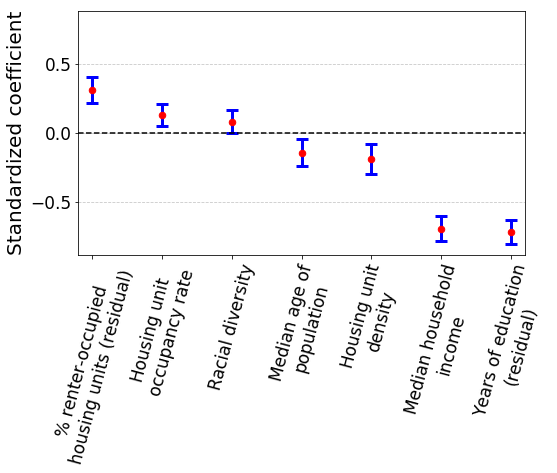

In [71]:
res = reg_results_delta_onset['subsidized_delta_normalized']
order_by_coefs = True
coef_list1 = []
CI_list1 = []
varname_list1 = []
for varname in res.index:
    if 'Intercept' in varname:
        continue
    coef = res.loc[varname, 'coef']
    std = res.loc[varname, 'std err']
    varname_list1.append(varname)
    coef_list1.append(coef)
    CI_list1.append(std * 1.96) # 1.96 for 95% CI, 2.58 for 99% CI

if order_by_coefs:
    coef_list1, CI_list1, varname_list1 = order_variables_by_coefs(coef_list1, CI_list1, varname_list1)

max_val1 = max([x+y for x, y in zip(coef_list1, CI_list1)])
min_val1 = min([x-y for x, y in zip(coef_list1, CI_list1)])

fig, ax = plt.subplots(figsize=(8, 4.5))
max_abs_val = max(abs(max_val1), abs(min_val1))
ax.errorbar(np.arange(len(coef_list1)), coef_list1, yerr=CI_list1, 
                                 linestyle='None', color='red', marker='.', markersize=13,
                                 elinewidth=3, ecolor='blue', capsize=6, capthick=3)

ax.set_ylim(-1.1*max_abs_val, 1.1*max_abs_val)
ax.set_xlim(-0.2, len(coef_list1) - 1 + 0.2)
ax.plot([-0.2, len(coef_list1) - 1 + 0.2], [0, 0], linestyle='--', color='black')
ax.set_xticks(range(len(coef_list1)))
ax.set_xticklabels([name_dict[x] for x in varname_list1], rotation=75)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylabel('Standardized coefficient', fontsize=20)
# ax.legend(fontsize=12, loc=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)
# ax.set_title('Dependent: relative savings with rebate/grant\nof PV in 2016', fontsize=20)

In [72]:
varname_order = [
#     'rate_LCOE_diff_calculated_avg',
#     'rate_LCOE_diff_calculated_2016',
    'rate_LCOE_diff_subsidized_calculated_avg',
    'rate_LCOE_diff_subsidized_calculated_2016',
    
    
    'ACS_occupancy_occupied_renter_rate_2016_residual',
    'ACS_edu_score_2016_residual',
    'ACS_housing_unit_density_2016',
    'ACS_age_median_2016',
    'ACS_diversity_NH_2016',
    'ACS_occupancy_occupied_rate_2016',
    'ACS_median_household_income_2016',
]

varname2position = {varname_order[i]: i for i in range(len(varname_order))}

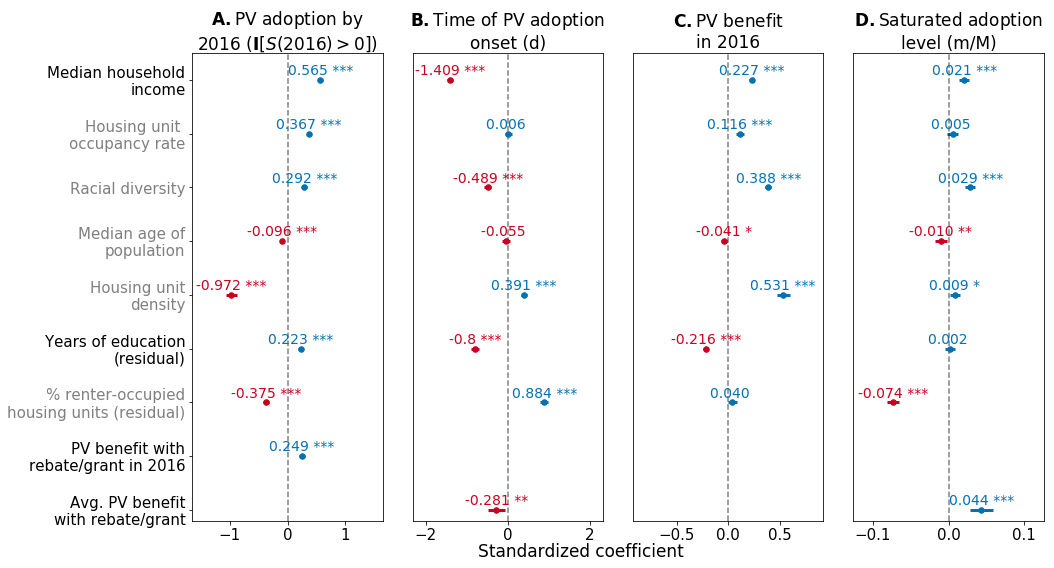

In [73]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))
# config_name = 'unsubsidized_delta_normalized'
results_to_plot = [
    reg_results_adoption_indicator['subsidized_delta_normalized_indicator'],
    reg_results_d['subsidized_delta_normalized_indicator'],
    reg_results_delta_2016['subsidized_delta_normalized'],
    reg_results_saturation_level['subsidized_delta_normalized_indicator'],
]
title_list = [
    r"$\bf{A.}$" + 'PV adoption by\n2016 ' + r"($\bf{I}$" + r"$[S(2016) > 0])$",
    r"$\bf{B.}$" + 'Time of PV adoption\nonset (d)',
#     r"$\bf{C.}$" + 'PV benefit with\nrebate/grant in 2016',
    r"$\bf{C.}$" + 'PV benefit\nin 2016',
    r"$\bf{D.}$" + 'Saturated adoption\nlevel (m/M)'
]
emphasized_vars = ['ACS_edu_score_2016_residual', 
                   'rate_LCOE_diff_subsidized_calculated_2016', 'rate_LCOE_diff_subsidized_calculated_avg',
                   'ACS_median_household_income_2016', 'rate_LCOE_diff_calculated_avg', 
                  'rate_LCOE_diff_calculated_2016']
for i, res in enumerate(results_to_plot):
    coef_list1 = []
    CI_list1 = []
    varname_list1 = []
    signifance_list1 = []
    for varname in res.index:
        if 'Intercept' in varname:
            continue
        if varname not in varname2position:
            continue
        coef = res.loc[varname, 'coef']
        std = res.loc[varname, 'std err']
        significance = res.loc[varname, 'significance']
        varname_list1.append(varname)
        coef_list1.append(coef)
        CI_list1.append(std * 1.96) # 1.96 for 95% CI, 2.58 for 99% CI
        signifance_list1.append(significance)
    coef_list1, CI_list1, varname_list1, signifance_list1 = order_variables_by_varnames(
        coef_list1, CI_list1, varname_list1, signifance_list1, varname_order=varname_order)
    
    
    max_val1 = max([x+y for x, y in zip(coef_list1, CI_list1)])
    min_val1 = min([x-y for x, y in zip(coef_list1, CI_list1)])
    max_abs_val = max(abs(max_val1), abs(min_val1))
    
    # plot positive coefs and negative coefs in different colors
    varname_list_pos, coef_list_pos, CI_list_pos, positions_pos = [], [], [], []
    varname_list_neg, coef_list_neg, CI_list_neg, positions_neg = [], [], [], []
    for x, y, z in zip(varname_list1, coef_list1, CI_list1):
        if y > 0:
            varname_list_pos.append(x)
            coef_list_pos.append(y)
            CI_list_pos.append(z) 
            positions_pos.append(varname2position[x])
        else:
            varname_list_neg.append(x)
            coef_list_neg.append(y)
            CI_list_neg.append(z)
            positions_neg.append(varname2position[x])
    
    if varname_list_pos:
        axes[i].errorbar(y=positions_pos, x=coef_list_pos, xerr=CI_list_pos, 
                                         linestyle='None', color='#0571b0', marker='.', markersize=11,
                                         elinewidth=3, ecolor='#0571b0')
    if varname_list_neg:
        axes[i].errorbar(y=positions_neg, x=coef_list_neg, xerr=CI_list_neg, 
                                         linestyle='None', color='#ca0020', marker='.', markersize=11,
                                         elinewidth=3, ecolor='#ca0020')

    axes[i].set_xlim(-1.55*max_abs_val, 1.55*max_abs_val)
    axes[i].set_ylim(-0.2, len(varname_order) - 1 + 0.5)
    axes[i].plot([0, 0], [-0.2, len(varname_order) - 1 + 0.5], linestyle='--', color='black', alpha=0.5)
    axes[i].tick_params(axis='x', which='major', labelsize=15, rotation=0)
    axes[i].set_yticks([])
    axes[i].set_title(title_list[i], fontsize=17)
#     axes[i].grid(axis='both', linestyle='--', alpha=0.7)

    # annotate text (coef + significance mark)
    for varname, c, mark in zip(varname_list1, coef_list1, signifance_list1):
        pos = varname2position[varname]
        color = '#0571b0' if c > 0 else '#ca0020'
        txt = str(round(c, 3))
        if len(txt.replace('-', '')) == 4:
            txt = txt + '0' # this is to append "0" at the end in case python round it up
        txt += ' ' + mark
        axes[i].text(c, pos+0.1, txt, fontsize=14, color=color, horizontalalignment='center')

axes[0].set_yticks(np.arange(len(varname_order)))
axes[0].set_yticklabels([name_dict[x] for x in varname_order])

axes[0].tick_params(axis='y', which='major', labelsize=15)

for j, x in enumerate(varname_order):
    if x not in emphasized_vars:
#         axes[0].get_yticklabels()[j].set_fontweight("bold")
        axes[0].get_yticklabels()[j].set_color("grey")
fig.text(0.55, 0.01, 'Standardized coefficient', ha='center', fontsize=17)
plt.tight_layout(pad=2)

# 3. By income level

In [74]:
color_dict = {
    'low_income_group': '#e66101',
    'midlow_income_group': '#fdb863',
    'midhigh_income_group': '#b2abd2',
    'high_income_group': '#5e3c99'
}
legend_dict = {
    'low_income_group': 'Low income',
    'midlow_income_group': 'Mid-low income',
    'midhigh_income_group': 'Mid-high income',
    'high_income_group': 'High income'
}

In [75]:
std_type = 'HC1'
se_cluster = 'county_FIPS'

In [ ]:
reg_results_saturation_level_by_income = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    reg_results = run_OLS_regression(merged3[merged3[group] == 1], configs_saturation_level, 
                                           std_type=std_type, fixed_effect='state_FIPS', cluster=se_cluster, 
                                           income_normalized_benefit=False, only_adoption=True)
    reg_results_saturation_level_by_income[group] = reg_results

In [ ]:
reg_results_d_by_income = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    reg_results = run_OLS_regression(merged3[merged3[group] == 1], configs_d, 
                                           std_type=std_type, fixed_effect='state_FIPS', cluster=se_cluster, 
                                           income_normalized_benefit=False, only_adoption=True)
    reg_results_d_by_income[group] = reg_results

In [ ]:
reg_results_delta_onset_by_income = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    reg_results = run_OLS_regression(merged3[merged3[group] == 1], configs_delta_onset, 
                                           std_type=std_type, fixed_effect='state_FIPS', cluster=se_cluster, 
                                           income_normalized_benefit=False, only_adoption=True)
    reg_results_delta_onset_by_income[group] = reg_results

In [ ]:
reg_results_delta_2016_by_income = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    reg_results = run_OLS_regression(merged3[merged3[group] == 1], configs_delta_2016, 
                                           std_type=std_type, fixed_effect='state_FIPS', cluster=se_cluster, 
                                           income_normalized_benefit=False, only_adoption=True)
    reg_results_delta_2016_by_income[group] = reg_results

In [ ]:
fixed_effect = 'state_FIPS'
cluster = se_cluster
income_normalized_benefit=False
only_adoption=False

reg_results_adoption_indicator_by_income = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    print(group)
    reg_results = {}
    df_income_group = merged3[merged3[group] == 1]
    for config_name in configs_adoption_indicator:
        config = configs_adoption_indicator[config_name]
        dependent = config['dependent']
        features = config['features'].copy()
        if income_normalized_benefit:
            if dependent in income_normalized_benefit_mapping:
                dependent = income_normalized_benefit_mapping[dependent]
            features_new = []
            for x in features:
                if x in income_normalized_benefit_mapping:
                    features_new.append(income_normalized_benefit_mapping[x])
                else:
                    features_new.append(x)
            features = features_new.copy()
        if fixed_effect and fixed_effect not in features:
            features.append(fixed_effect)
        incentive_indicators = config['incentive_indicators']
        normalize_features = config['normalize_features']
        if incentive_indicators:
            features.extend(incentive_indicators)
        other_vars = []
        if std_type == 'cluster' and cluster not in features:
            other_vars.append(cluster)
        if only_adoption:
            df_reg = df_income_group[df_income_group['d'].isnull() == False][features + [dependent] + other_vars]
        else:
            df_reg = df_income_group[features + [dependent] + other_vars]
        if normalize_features:
            for feature in features:
                if feature != 'state_FIPS':
                    df_reg[feature] = (df_reg[feature] - df_reg[feature].mean()) / df_reg[feature].std()
        if 'interaction_features' in config:
            features.extend(config['interaction_features'])
        fmla = make_str(dependent, features)
        if std_type == 'cluster':
            df_reg = df_reg.dropna()
            %R -i fmla
            %R -i df_reg
            %R -i cluster
            %R -i std_type
            %R library(lmtest)
            %R library(sandwich)

            %R model <- glm(fmla, family = binomial(link = "logit"), data = df_reg) 
            %R coeftest_results <- coeftest(model, vcov. = vcovCL(model, cluster = df_reg[[cluster]], type = "HC0"))
            %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
            %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
        else:
            %R -i fmla
            %R -i df_reg
            %R -i cluster
            %R -i std_type
            %R library(lmtest)
            %R library(sandwich)

            %R model <- glm(fmla, family = binomial(link = "logit"), data = df_reg) 
            %R coeftest_results <- coeftest(model, vcov = vcovHC, type = std_type)
            %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
            %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')

        classification_results = pd.read_csv('results/tmp_regression_results.csv')
        classification_results.index = classification_results['Unnamed: 0']
        del classification_results['Unnamed: 0']
        classification_results.columns = ['coef', 'std err', 'z', 'P>|z|']
        classification_results = classification_results.loc[[x for x in classification_results.index if 'state' not in x], :]
        l = []
        for x in classification_results.index:
            pval = classification_results.loc[x, 'P>|z|']
            if pval < 0.001:
                star = '***'
            elif pval < 0.01:
                star = '**'
            elif pval < 0.05:
                star = '*'
            else:
                star = ''
            l.append(star)
        classification_results['significance'] = l
        reg_results[config_name] = classification_results
    reg_results_adoption_indicator_by_income[group] = reg_results


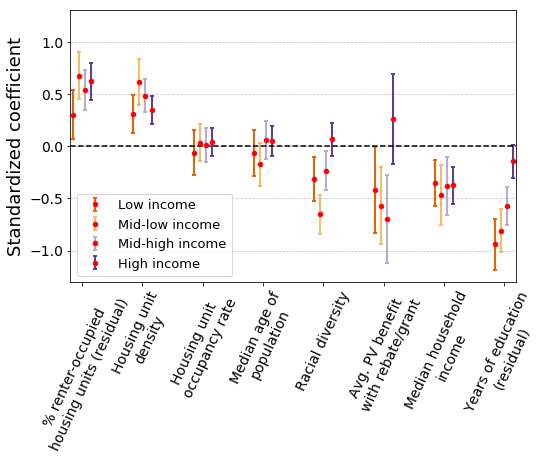

In [81]:
config_name = 'subsidized_delta_normalized_indicator'
res_results_to_plot = reg_results_d_by_income.copy()
max_abs_val = 0
fig, ax = plt.subplots(figsize=(8, 5))
avg_coef_dict = {}
for i, group in enumerate(['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']):
    res = res_results_to_plot[group][config_name]
    for varname in res.index:
        if 'Intercept' in varname or 'incentive' in varname:
            continue
        coef = res.loc[varname, 'coef']
        std = res.loc[varname, 'std err']
        if not varname in avg_coef_dict:
            avg_coef_dict[varname] = [coef, std * 1.96, 1]
        else:
            avg_coef_dict[varname][0] += coef
            avg_coef_dict[varname][1] += std * 1.96
            avg_coef_dict[varname][2] += 1

for varname in avg_coef_dict:
    avg_coef_dict[varname][0] = avg_coef_dict[varname][0] / avg_coef_dict[varname][2]
    avg_coef_dict[varname][1] = avg_coef_dict[varname][1] / avg_coef_dict[varname][2]
varname_order_list = sorted(list(avg_coef_dict), key=lambda x: avg_coef_dict[x][0], reverse=True)

for i, group in enumerate(['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']):
    res = res_results_to_plot[group][config_name]
    coef_list1 = []
    CI_list1 = []
    varname_list1 = []
    for varname in res.index:
        if 'Intercept' in varname or 'incentive' in varname:
            continue
        coef = res.loc[varname, 'coef']
        std = res.loc[varname, 'std err']
        varname_list1.append(varname)
        coef_list1.append(coef)
        CI_list1.append(std * 1.96) # 1.96 for 95% CI, 2.58 for 99% CI
    coef_list1, CI_list1, varname_list1 = order_variables_by_varnames(coef_list1, CI_list1, varname_list1, 
                                                                      varname_order=varname_order_list)
    max_val1 = max([x+y for x, y in zip(coef_list1, CI_list1)])
    min_val1 = min([x-y for x, y in zip(coef_list1, CI_list1)])
    max_abs_val = max(max_abs_val, abs(max_val1), abs(min_val1))
    ax.errorbar(np.arange(len(coef_list1)) + i * 0.1 - 0.15, coef_list1, yerr=CI_list1, 
                                     linestyle='None', color='red', marker='.', markersize=9,
                                     elinewidth=2, ecolor=color_dict[group], capsize=2, capthick=2,
                                     label=legend_dict[group])

ax.set_ylim(-1.1*max_abs_val, 1.1*max_abs_val)
ax.set_xlim(-0.2, len(coef_list1) - 1 + 0.2)
ax.plot([-0.2, len(coef_list1) - 1 + 0.2], [0, 0], linestyle='--', color='black')
ax.set_xticks(range(len(coef_list1)))
ax.set_xticklabels([name_dict[x] for x in varname_list1], rotation=65)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Standardized coefficient', fontsize=18)
ax.legend(fontsize=13, loc=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

In [82]:
selected_incentive_types = [
    'incentive_pace_financing',
    'incentive_performance_based_incentive',
    'incentive_rebate_program',
    'incentive_grant_program',
    'incentive_loan_program',
    'incentive_property_tax_incentive',
]

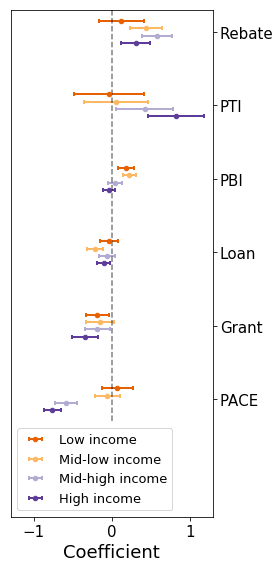

In [83]:
config_name = 'unsubsidized_delta_indicator'
res_results_to_plot = reg_results_saturation_level_by_income.copy()
max_abs_val = 0
fig, ax = plt.subplots(figsize=(4, 8))
avg_coef_dict = {}
for i, group in enumerate(['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']):
    res = res_results_to_plot[group][config_name]
    for varname in res.index:
        if 'incentive' not in varname or varname not in selected_incentive_types:
            continue
        coef = res.loc[varname, 'coef']
        std = res.loc[varname, 'std err']
        if not varname in avg_coef_dict:
            avg_coef_dict[varname] = [coef, std * 1.96, 1]
        else:
            avg_coef_dict[varname][0] += coef
            avg_coef_dict[varname][1] += std * 1.96
            avg_coef_dict[varname][2] += 1

for varname in avg_coef_dict:
    avg_coef_dict[varname][0] = avg_coef_dict[varname][0] / avg_coef_dict[varname][2]
    avg_coef_dict[varname][1] = avg_coef_dict[varname][1] / avg_coef_dict[varname][2]
varname_order_list = sorted(list(avg_coef_dict), key=lambda x: avg_coef_dict[x][0], reverse=False)

for i, group in enumerate(['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']):
    res = res_results_to_plot[group][config_name]
    coef_list1 = []
    CI_list1 = []
    varname_list1 = []
    signifance_list1 = []
    for varname in configs_saturation_level[config_name]['incentive_indicators']:
        if 'incentive' not in varname or varname not in selected_incentive_types:
            continue
        if varname in res.index:
            coef = res.loc[varname, 'coef']
            std = res.loc[varname, 'std err']
            significance = res.loc[varname, 'significance']
        else:
            coef = np.nan
            std = np.nan
        varname_list1.append(varname)
        coef_list1.append(coef)
        CI_list1.append(std * 1.96) # 1.96 for 95% CI, 2.58 for 99% CI
        signifance_list1.append(significance)
        coef_list1, CI_list1, varname_list1 = order_variables_by_varnames(coef_list1, CI_list1, varname_list1, 
                                                                      varname_order=varname_order_list)

    max_val1 = max([x+y for x, y in zip(coef_list1, CI_list1) if np.isnan(x) == False])
    min_val1 = min([x-y for x, y in zip(coef_list1, CI_list1) if np.isnan(x) == False])
    max_abs_val = max(max_abs_val, abs(max_val1), abs(min_val1))
    ax.errorbar(y=np.arange(len(coef_list1)) - i * 0.1 + 0.15, x=coef_list1, xerr=CI_list1, 
                                     linestyle='None', color=color_dict[group], marker='.', markersize=9,
                                     elinewidth=2, ecolor=color_dict[group], capsize=2, capthick=2, 
                                     label=legend_dict[group])
    
ax.yaxis.tick_right()
ax.set_xlim(-1.1*max_abs_val, 1.1*max_abs_val)
ax.set_ylim(-1.6, len(coef_list1) - 1 + 0.3)
ax.plot([0, 0], [-0.3, len(coef_list1) - 1 + 0.3], linestyle='--', color='black', alpha=0.5)
ax.set_yticks(range(len(coef_list1)))
ax.set_yticklabels([name_dict[x] for x in varname_list1], rotation=0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Coefficient', fontsize=18)
ax.legend(fontsize=13, loc=3)
plt.tight_layout()
# ax.grid(axis='x', linestyle='--', alpha=0.7)

# 4. Run adoption indicator vs incentive indicators for each year

In [84]:
configs_adoption_indicator_by_year = {
    'unsubsidized_delta_indicator': {
        'dependent': 'installation_indicator_year',
        'features': [
            'ACS_median_household_income_2016',
            'ACS_housing_unit_density_2016',
            'ACS_diversity_NH_2016',
            'ACS_age_median_2016',
            'ACS_occupancy_occupied_rate_2016',
            'ACS_edu_score_2016_residual',
            'ACS_occupancy_occupied_renter_rate_2016_residual',
        ],
        'economic_features': [
            'rate_LCOE_diff_calculated',
        ],
        'incentive_indicators': all_incentive_types,
        'normalize_features': False,
    },
}

In [ ]:
std_type = 'HC1'
cluster = 'county_FIPS'
col_as_anchor_year = 'predicted_1st_adoption_time_rounded'
config_name = 'unsubsidized_delta_indicator'
reg_results_adoption_indicator_by_year = {}
adoption_indicator_stats_dict = {}
df_reg_dict = {}
config = configs_adoption_indicator_by_year[config_name]
dependent = config['dependent']
features = config['features'].copy()
incentive_indicators = config['incentive_indicators']
normalize_features = config['normalize_features']
economic_features = config['economic_features']
features_all = features + incentive_indicators + economic_features

for year in range(2006, 2017):
    # exclude all block groups that started adoption before "year"
    merged_sub = merged3[(merged3[col_as_anchor_year] >= year) | merged3[col_as_anchor_year].isnull()]
    merged_sub['installation_indicator_year'] = merged_sub[col_as_anchor_year] == year
    adoption_indicator_stats_dict[year] = [len(merged_sub), np.sum(merged_sub['installation_indicator_year'] == 1)]
    
    if 'state_FIPS' not in features:
        df_reg = merged_sub[features + [dependent] + ['blockgroup_FIPS', 'state_FIPS']]
    else:
        df_reg = merged_sub[features + [dependent] + ['blockgroup_FIPS']]
    df_reg['county_FIPS'] = df_reg['blockgroup_FIPS'] // 10000000
    df_reg['county_FIPS'] = df_reg['county_FIPS'].astype(str)
    
    # incorporate year-specific incentive type indicators
    incentive_type_indicator_bg_sub = incentive_type_indicator_bg[incentive_type_indicator_bg['year'] == year]
    df_reg = pd.merge(df_reg, incentive_type_indicator_bg_sub, on='blockgroup_FIPS', how='left')
    df_reg = pd.merge(df_reg, 
            cost_benefit_df[cost_benefit_df['year'] == year][['blockgroup_FIPS'] + economic_features],
            on='blockgroup_FIPS', how='left')
    if 'state_FIPS' not in features_all:
        df_reg = df_reg[features_all + [dependent, 'blockgroup_FIPS', 'county_FIPS', 'state_FIPS']]
    else:
        df_reg = df_reg[features_all + [dependent, 'blockgroup_FIPS', 'county_FIPS']]
    df_reg['blockgroup_FIPS'] = df_reg['blockgroup_FIPS'].astype(str)
    df_reg_dict[year] = df_reg ##
    if normalize_features:
        for feature in features_all:
            if feature != 'state_FIPS':
                df_reg[feature] = (df_reg[feature] - df_reg[feature].mean()) / df_reg[feature].std()
    if 'interaction_features' in config:
        features_all.extend(config['interaction_features'])
    fmla = make_str(dependent, features_all)
    if std_type == 'cluster':
        df_reg = df_reg.dropna()
        %R -i fmla
        %R -i df_reg
        %R -i cluster
        %R library(lmtest)
        %R library(sandwich)
        %R model <- glm(fmla, family = binomial(link = "logit"), data = df_reg) 
        %R coeftest_results <- coeftest(model, vcov. = vcovCL(model, cluster = df_reg[[cluster]], type = "HC0"))
        %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
        %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
    else:
        %R -i fmla
        %R -i df_reg
        %R -i cluster
        %R -i std_type
        %R library(lmtest)
        %R library(sandwich)
        %R model <- glm(fmla, family = binomial(link = "logit"), data = df_reg) 
        %R coeftest_results <- coeftest(model, vcov = vcovHC, type = std_type)
        %R coeftest_results_df <- as.data.frame.matrix(coeftest_results)
        %R write.csv(coeftest_results_df, 'results/tmp_regression_results.csv')
    classification_results = pd.read_csv('results/tmp_regression_results.csv')
    classification_results.index = classification_results['Unnamed: 0']
    del classification_results['Unnamed: 0']
    classification_results.columns = ['coef', 'std err', 'z', 'P>|z|']
    l = []
    for x in classification_results.index:
        pval = classification_results.loc[x, 'P>|z|']
        if pval < 0.001:
            star = '***'
        elif pval < 0.01:
            star = '**'
        elif pval < 0.05:
            star = '*'
        else:
            star = ''
        l.append(star)
    classification_results['significance'] = l
    reg_results_adoption_indicator_by_year[year] = classification_results
    

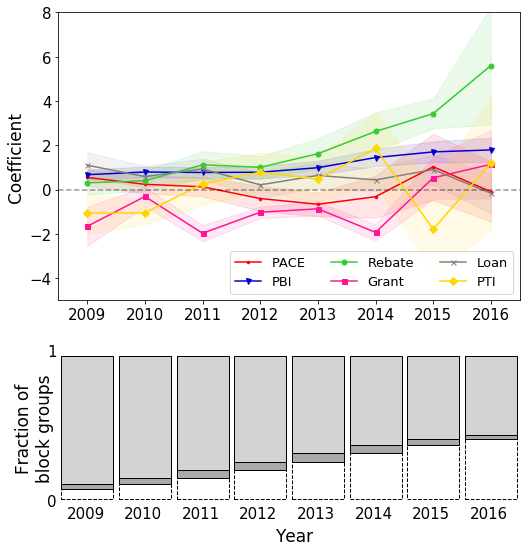

In [90]:
# no state FE, robust SE
fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})
incentive_types = [
    'incentive_pace_financing',
    'incentive_performance_based_incentive',
    'incentive_rebate_program',
    'incentive_grant_program',
    'incentive_loan_program',
    'incentive_property_tax_incentive',
]
color_list = ['red', 'mediumblue', 'limegreen', 'deeppink', 'gray', 'gold', 'purple', 'black', 'cyan', 
              'magenta']
marker_list = ['.', 'v', 'o', 's', 'x', 'D', '.', 'v', 'o', 's']
for i, x in enumerate(incentive_types):
    year_list = []
    coef_list1 = []
    upper_list = []
    bottom_list = []
    color = color_list[i]
    for year in range(2009, 2017):
        res = reg_results_adoption_indicator_by_year[year]
        if x not in res.index:
            continue
        coef = res.loc[x, 'coef']
        std = res.loc[x, 'std err']
        year_list.append(year)
        coef_list1.append(coef)
        upper_list.append(coef + std * 1.96) # 1.96 for 95% CI, 2.58 for 99% CI
        bottom_list.append(coef - std * 1.96) # 1.96 for 95% CI, 2.58 for 99% CI
    axes[0].plot(year_list, coef_list1, color=color, label=name_dict[x], marker=marker_list[i], markersize=5)
    axes[0].fill_between(year_list, upper_list, bottom_list, color=color, alpha=0.1)
axes[0].plot([2008.5, 2016.5], [0, 0], color='black', ls='--', alpha=0.4)
axes[0].set_xlim(2008.5, 2016.5)
axes[0].set_ylim(-5, 8)
# axes[0].set_ylim(-3, 3)

axes[1].set_xlabel('Year', fontsize=17)
axes[0].set_xticks(year_list)
# axes[0].set_xticklabels([''] * 6)
axes[0].set_ylabel('Coefficient', fontsize=17)
axes[0].tick_params(axis='both', which='major', labelsize=15)

frac1_list, frac2_list, frac3_list = [], [], []
for year in year_list:
    base, npos = adoption_indicator_stats_dict[year]
    frac1 = (len(merged3) - base) / len(merged3) # # fraction of BGs that started adoption before year t
    frac2 = npos / len(merged3) # fraction of BGs that started adoption in year t
    frac3 = (base - npos) / len(merged3) # fraction of BGs that started adoption after year t
    frac1_list.append(frac1)
    frac2_list.append(frac2)
    frac3_list.append(frac3)
axes[1].bar(year_list, frac1_list, width=0.9, color='white', linestyle='--', hatch=None, edgecolor='black')
axes[1].bar(year_list, frac2_list, bottom=np.array(frac1_list), width=0.9, color='darkgrey', 
            linestyle='-', hatch=None, edgecolor='black')
axes[1].bar(year_list, frac3_list, bottom=np.array(frac1_list)+np.array(frac2_list), width=0.9, color='lightgrey',
           linestyle='-', hatch=None, edgecolor='black')
axes[1].set_ylim(-0.01, 1)
axes[1].set_xticks([])

axes[1].set_xlim(2008.5, 2016.5)
axes[1].set_axis_off()
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels([0, 1])
fig.text(0.13, 0.08, '0', fontsize=15, ha='center')
fig.text(0.13, 0.34, '1', fontsize=15, ha='center')
fig.text(0.1, 0.25, 'Fraction of\nblock groups', fontsize=17, ha='center', rotation='vertical')
fig.text(0.55, 0.02, 'Year', fontsize=17, ha='center')
for i, year in enumerate(year_list):
    fig.text(0.155 + 0.8 * i / len(year_list), 0.06, str(year), fontsize=15)

axes[0].legend(fontsize=13, ncol=3, loc=4)
plt.tight_layout(pad=3.0)
# # plt.ylim()